In [3]:
from pathlib import Path
from models import utils as mutils
from sde_lib import VESDE
from sampling import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      get_pc_fouriercs_fast)
from models import ncsnpp
import time
from utils import fft2, ifft2, get_mask, get_data_scaler, get_data_inverse_scaler, restore_checkpoint
import torch
import torch.nn as nn
import numpy as np
from models.ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import importlib
import argparse
from PIL import Image


def main():
    ###############################################
    # 1. Configurations
    ###############################################

    # args
    args = create_argparser().parse_args()
    N = args.N
    m = args.m
    # fname = '001'
    fname = args.data
    filename = f'./samples/real/{args.task}/{fname}.npy'
    mask_filename = f'./samples/real/prospective/{fname}_mask.npy'

    print('initializing...')
    configs = importlib.import_module(f"configs.ve.fastmri_knee_320_ncsnpp_continuous")
    config = configs.get_config()
    img_size = config.data.image_size
    batch_size = 1

    # Read data
    img = torch.from_numpy(np.load(filename))
    img = img.view(1, 1, 320, 320)
    img = img.to(config.device)
    if args.task == 'retrospective':
        # generate mask
        mask = get_mask(img, img_size, batch_size,
                        type=args.mask_type,
                        acc_factor=args.acc_factor,
                        center_fraction=args.center_fraction)
    elif args.task == 'prospective':
        mask = torch.from_numpy(np.load(mask_filename))
        mask = mask.view(1, 1, 320, 320)

    ckpt_filename = f"./weights/checkpoint_95.pth"
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=N)

    config.training.batch_size = batch_size
    predictor = ReverseDiffusionPredictor
    corrector = LangevinCorrector
    probability_flow = False
    snr = 0.16

    # sigmas = mutils.get_sigmas(config)
    scaler = get_data_scaler(config)
    inverse_scaler = get_data_inverse_scaler(config)

    # create model and load checkpoint
    score_model = mutils.create_model(config)
    ema = ExponentialMovingAverage(score_model.parameters(),
                                   decay=config.model.ema_rate)
    state = dict(step=0, model=score_model, ema=ema)
    state = restore_checkpoint(ckpt_filename, state, config.device, skip_sigma=True)
    ema.copy_to(score_model.parameters())

    # Specify save directory for saving generated samples
    save_root = Path(f'./results/real')
    save_root.mkdir(parents=True, exist_ok=True)

    irl_types = ['input', 'recon', 'recon_progress', 'label']
    for t in irl_types:
        save_root_f = save_root / t
        save_root_f.mkdir(parents=True, exist_ok=True)


    #save MASK
    mask_np = mask.squeeze().numpy()
    mask_img = Image.fromarray(mask_np.astype(np.uint8))
    plt.imsave(str(save_root / 'mask' / fname) + '.png', mask)

    ###############################################
    # 2. Inference
    ###############################################

    pc_fouriercs = get_pc_fouriercs_fast(sde,
                                         predictor, corrector,
                                         inverse_scaler,
                                         snr=snr,
                                         n_steps=m,
                                         probability_flow=probability_flow,
                                         continuous=config.training.continuous,
                                         denoise=True,
                                         save_progress=True,
                                         save_root=save_root / 'recon_progress')
    # fft
    kspace = fft2(img)

    # undersampling
    under_kspace = kspace * mask
    under_img = torch.real(ifft2(under_kspace))
    
    #save undersampled K-SPACE
    plt.imsave(str(save_root / 'under_kspace' / fname) + '.png', under_kspace)
    
    
    print(f'Beginning inference')
    tic = time.time()
    x = pc_fouriercs(score_model, scaler(under_img), mask, Fy=under_kspace)
    toc = time.time() - tic
    print(f'Time took for recon: {toc} secs.')

    ###############################################
    # 3. Saving recon
    ###############################################
    
    # if args.task == 'retrospective':
    #     # save input and label only if this is retrospective recon.
    #     input = under_img.squeeze().cpu().detach().numpy()
    #     label = img.squeeze().cpu().detach().numpy()
    #     mask_sv = mask.squeeze().cpu().detach().numpy()

    #     np.save(str(save_root / 'input' / fname) + '.npy', input)
    #     np.save(str(save_root / 'input' / (fname + '_mask')) + '.npy', mask_sv)
    #     plt.imsave(str(save_root / 'input' / (fname+'_under_kspace') + '.png', under_kspace)
    #     np.save(str(save_root / 'label' / fname) + '.npy', label)
    #     plt.imsave(str(save_root / 'input' / fname) + '.png', input, cmap='gray')
    #     plt.imsave(str(save_root / 'label' / fname) + '.png', label, cmap='gray')


    # recon = x.squeeze().cpu().detach().numpy()
    # np.save(str(save_root / 'recon' / fname) + '.npy', recon)
    # plt.imsave(str(save_root / 'recon' / fname) + '.png', recon, cmap='gray')


# def create_argparser():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--task', choices=['retrospective', 'prospective'], default='retrospective',
#                         type=str, help='If retrospective, under-samples the fully-sampled data with generated mask.'
#                                        'If prospective, runs score-POCS with the given mask')
#     parser.add_argument('--data', type=str, help='which data to use for reconstruction', required=True)
#     parser.add_argument('--mask_type', type=str, help='which mask to use for retrospective undersampling.'
#                                                       '(NOTE) only used for retrospective model!', default='gaussian1d',
#                         choices=['gaussian1d', 'uniform1d', 'gaussian2d'])
#     parser.add_argument('--acc_factor', type=int, help='Acceleration factor for Fourier undersampling.'
#                                                        '(NOTE) only used for retrospective model!', default=4)
#     parser.add_argument('--center_fraction', type=float, help='Fraction of ACS region to keep.'
#                                                        '(NOTE) only used for retrospective model!', default=0.08)
#     parser.add_argument('--save_dir', default='./results')
#     parser.add_argument('--N', type=int, help='Number of iterations for score-POCS sampling', default=2000)
#     parser.add_argument('--m', type=int, help='Number of corrector step per single predictor step.'
#                                               'It is advised not to change this default value.', default=1)
#     return parser


# if __name__ == "__main__":
#     main()

In [5]:
filename = f'./samples/real/retrospective/001.npy'
mask_filename = f'./samples/real/prospective/001_mask.npy'

print('initializing...')
configs = importlib.import_module(f"configs.ve.fastmri_knee_320_ncsnpp_continuous")
config = configs.get_config()
img_size = config.data.image_size
batch_size = 1

# Read data
img = torch.from_numpy(np.load(filename))
img = img.view(1, 1, 320, 320)
img = img.to(config.device)
mask_filename = f'./samples/real/prospective/{0o001}_mask.npy'

initializing...


In [61]:
type='gaussian1d'
mask = get_mask(img, img_size, batch_size,
                        type='gaussian1d',
                        acc_factor=4,
                        center_fraction=0.08)

In [62]:
mask

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [63]:
ckpt_filename = f"./weights/checkpoint_95.pth"
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=200)

config.training.batch_size = batch_size
predictor = ReverseDiffusionPredictor
corrector = LangevinCorrector
probability_flow = False
snr = 0.16

# sigmas = mutils.get_sigmas(config)
scaler = get_data_scaler(config)
inverse_scaler = get_data_inverse_scaler(config)

In [64]:
# create model and load checkpoint
fname = '002'
m = 1 
N=200
score_model = mutils.create_model(config)
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, model=score_model, ema=ema)
state = restore_checkpoint(ckpt_filename, state, config.device, skip_sigma=True)
ema.copy_to(score_model.parameters())

# Specify save directory for saving generated samples
save_root = Path(f'./results/real')
save_root.mkdir(parents=True, exist_ok=True)

irl_types = ['input', 'recon', 'recon_progress', 'label']
for t in irl_types:
    save_root_f = save_root / t
    save_root_f.mkdir(parents=True, exist_ok=True)


#save MASK
mask_np = mask.squeeze().numpy()
mask_img = Image.fromarray(mask_np.astype(np.uint8))
plt.imsave(str(save_root / 'mask' / fname) + '.png', mask)

###############################################
# 2. Inference
###############################################

pc_fouriercs = get_pc_fouriercs_fast(sde,
                                     predictor, corrector,
                                     inverse_scaler,
                                     snr=snr,
                                     n_steps=m,
                                     probability_flow=probability_flow,
                                     continuous=config.training.continuous,
                                     denoise=True,
                                     save_progress=True,
                                     save_root=save_root / 'recon_progress')
# fft
kspace = fft2(img)

# undersampling
under_kspace = kspace * mask
under_img = torch.real(ifft2(under_kspace))

#save undersampled K-SPACE
#plt.imsave(str(save_root / 'input' / (fname+'_under_kspace') + '.png', under_kspace))
und_k = under_kspace.squeeze().numpy()

loaded checkpoint dir from ./weights/checkpoint_95.pth


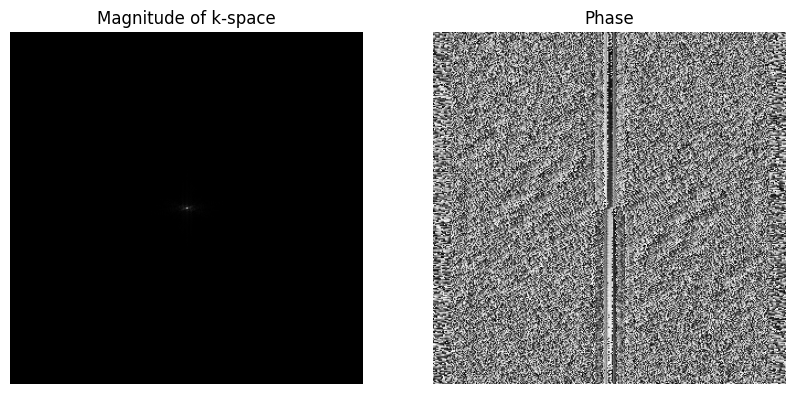

In [65]:
kspace_mag = np.abs(kspace.squeeze().numpy())
kspace_phase = np.angle(kspace.squeeze().numpy())

# Display k-space image with magnitude and phase information
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(kspace_mag, cmap='gray')
plt.title('Magnitude of k-space')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(kspace_phase, cmap='gray')  # Use 'hsv' colormap for phase
plt.title('Phase')

#plt.colorbar()  # Add color bar for phase
plt.axis("off")
plt.show()

In [66]:
mask_np = mask.squeeze().numpy() 

# plt.imshow(mask_np, cmap='gray')  # You can specify colormap according to your needs
# plt.title(f"Undersampling mask - {type}")
# plt.axis("off")
# plt.show()

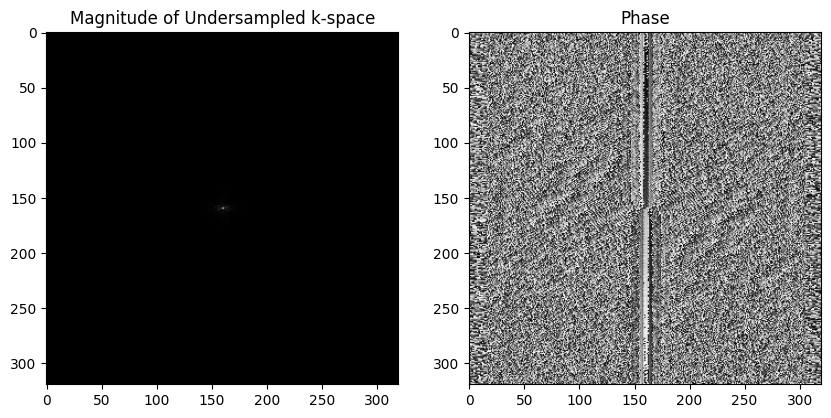

In [67]:
# plt.imshow(np.real(und_k),cmap='gray')
kspace_under = np.abs(under_kspace.squeeze().numpy())
kspace_under_phase = np.angle(under_kspace.squeeze().numpy())

# Display k-space image with magnitude and phase information
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(kspace_under, cmap='gray')
plt.title('Magnitude of Undersampled k-space')

plt.subplot(1, 2, 2)
plt.imshow(kspace_phase, cmap='gray')  # Use 'hsv' colormap for phase
plt.title('Phase')

#plt.colorbar()  # Add color bar for phase
plt.show()

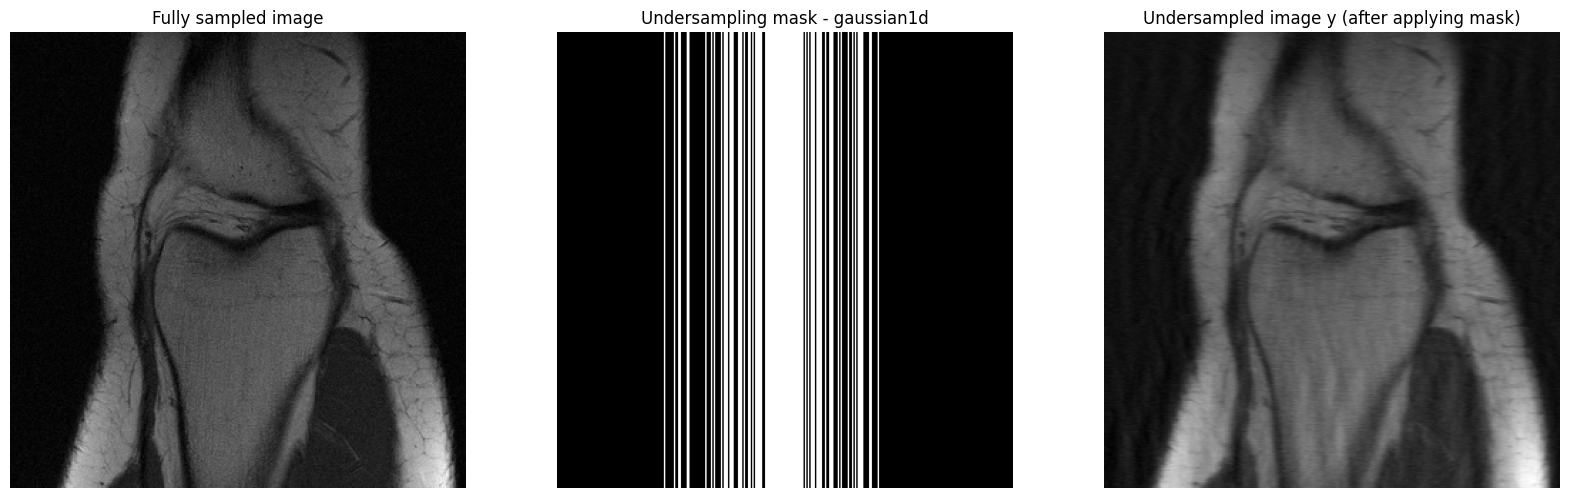

In [68]:
under_img1 = under_img.squeeze().numpy()

# Display k-space image with magnitude and phase information
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title('Fully sampled image')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')  # You can specify colormap according to your needs
plt.title(f"Undersampling mask - {type}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(under_img1, cmap='gray')  # Use 'hsv' colormap for phase
plt.title('Undersampled image y (after applying mask)')
plt.axis("off")

# plt.colorbar()  # Add color bar for phase
plt.show()

In [44]:
print(f'Beginning inference')
tic = time.time()
x = pc_fouriercs(score_model, scaler(under_img), mask, Fy=under_kspace)
toc = time.time() - tic
print(f'Time took for recon: {toc} secs.')

Beginning inference


  0%|                                                                                          | 0/200 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [95]:
recon = x.squeeze().cpu().detach().numpy()

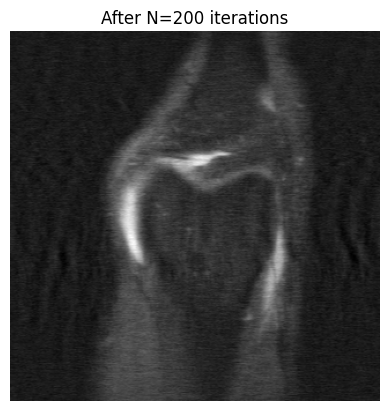

In [96]:
plt.imshow(recon, cmap='gray')
plt.imshow(under_img1, cmap='gray')  
plt.title(f"After N={N} iterations")
plt.axis("off")
plt.show()